# Data Wrangling & Exploratory Data Analysis

## Cleaning of scraped data

This section focuses on cleaning of the raw data which was scraped of the following websites:
- [Yahoo Finance](yahoo.finance/cryptocurrencies)
- [Coin Market](Capcoinmarketcap.com)
- [Coindesk](coindesk.com)

Also check following file 👉 [Main.py](https://github.com/mr-emreerturk/crypto_scraping_project/blob/main/main.py) and the [README](https://github.com/mr-emreerturk/crypto_scraping_project/blob/main/README.md)for more context.

### Imports & Constants


In [34]:
# Import all necesssary modules
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Define file path of H5 file as constant
PATH = "/Users/emre/Documents/GitHub/crypto_scraping_project/data.h5"

### Loading files into dataframes


In [35]:
# https://stackoverflow.com/questions/40472912/hdf5-file-to-pandas-dataframe
# Read all datasets into dataframes by transforming the h5 file into an array first
df_prices = pd.DataFrame(np.array(h5py.File(PATH)["yahoo_prices"]))
df_news = pd.DataFrame(np.array(h5py.File(PATH)["news_data"]))
df_dev = pd.DataFrame(np.array(h5py.File(PATH)["dev_data"]))

### Convert all entries to strings

In [36]:
df_prices = df_prices.astype("str")
df_dev = df_dev.astype("str")
df_news = df_news.astype("str")

### Replace import substrings "b" & "''"

In [37]:
# Elimate imported string b & ''
df_list_mask = [df_prices, df_dev, df_news]  # list of all dataframes
for x in df_list_mask:  # loop through all dataframes
    for n in range(0, len(x.columns)):  # loop through columns of each df
        for m in range(0, len(x)):  # loop through length of rows
            x[n][m] = (
                x[n][m].replace("b'", "").replace("'", "")
            )  # Replace substring "b & ''"

### Change column names

In [38]:
# Change column names
df_prices = df_prices.rename(
    {
        0: "date",
        1: "name",
        2: "price",
        3: "market_cap",
        4: "circulating_supply",
    },
    axis=1,
)

df_dev = df_dev.rename(
    {
        0: "date",
        1: "name",
        2: "github_commits",
        3: "github_stars",
        4: "github_forks",
        5: "github_contributors",
        6: "github_followers",
        7: "twitter_followers",
        8: "reddit_members",
    },
    axis=1,
)


df_news = df_news.rename(
    {
        0: "date",
        1: "name",
        2: "amount_news_articles",
    },
    axis=1,
)

### Standartize crypto names in `df_prices`

#### Filter to crypto used in other dataframes

In [39]:
# Drop last 3 letters "USD", strip all whitespace from head & tail of string, and add hypen between words when whitespace
df_prices.name = df_prices.name.str[:-3].str.lower().str.strip().str.replace(" ", "-")

top_crypto = [ # Filter for crypto used in other datasets
        "bitcoin",
        "ethereum",
        "tether",
        "usd-coin",
        "bnb",
        "xrp",
        "binance-usd",
        "cardano",
        "solana",
        "dogecoin",
        "polygon",
        "tron",
    ]

df_prices = df_prices[df_prices.name.isin(top_crypto)]

### Correction of dtypes

In [40]:
# Change dtypes of columns
from numpy import NaN #import numpy's NaN

# Change date dtype in df_prices
df_prices.date = pd.to_datetime(df_prices.date)

df_prices.price = df_prices.price.apply(
    lambda x: float(x.replace(",", ""))
)  # Remove comma from number and covnert to float

df_prices.market_cap = df_prices.market_cap.apply(
    lambda x: float(x.strip("B")) * 1_000_000_000
)  # Replace billion with real number in market_cap column

df_prices.circulating_supply = df_prices.circulating_supply.apply(
    lambda x: float(x.strip("B")) * 1_000_000_000
    if (x[-1] == "B")
    else float(x.strip("M")) * 1_000_000
) # Replace billion and million with real number in circulating supply column

# Change date in df_dev
df_dev.date = pd.to_datetime(df_dev.date)
# Replace '--' with NaN and convert to float
for x in df_dev.columns:
    df_dev[x] = df_dev[x].replace("--", np.nan, regex=True)
df_dev.loc[:,"github_commits":"reddit_members"] = df_dev.loc[:,"github_commits":"reddit_members"].astype(float).round(0)

# Change date in df_news
df_news.date = pd.to_datetime(df_news.date)
# Change dtype of amount_news_articles to int
df_news.amount_news_articles = df_news.amount_news_articles.astype(int)

/var/folders/9c/dzx7wkbs2sn6_g919b67k6yc0000gn/T/ipykernel_3854/2069303491.py:26: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_dev.loc[:,"github_commits":"reddit_members"] = df_dev.loc[:,"github_commits":"reddit_members"].astype(float).round(0)


### Concat all dataframes in one big dataframe

In [41]:
for x in [df_prices,df_dev,df_news]:
    x.sort_values(by="name",inplace=True) # Sort all dataframes

# Merge dataframes on an inner join on "date" and "name"
df_mask = df_prices.merge(df_dev, how="inner", left_on=["date", "name"], right_on=["date", "name"])
df = df_mask.merge(df_news, how="inner", left_on=["date", "name"], right_on=["date", "name"])

In [42]:
df = df.sort_values(by=["date", "name"]).reset_index(drop=True) # Sorting final dataframe
df

,date,name,price,market_cap,circulating_supply,github_commits,github_stars,github_forks,github_contributors,github_followers,twitter_followers,reddit_members,amount_news_articles
0,2022-11-01,binance-usd,1.000900,2.141400e+10,2.139500e+10,10.0,96.0,76.0,5.0,23.0,9710408.0,NaN,0
1,2022-11-01,bitcoin,20457.650000,3.926970e+11,1.919600e+07,35791.0,66721.0,33228.0,881.0,3925.0,NaN,4668711.0,22
2,2022-11-01,cardano,0.403617,1.385700e+10,3.433100e+10,NaN,NaN,NaN,NaN,NaN,1342071.0,697086.0,0
3,2022-11-01,dogecoin,0.139730,1.853800e+10,1.326710e+11,14211.0,14188.0,2624.0,272.0,851.0,3512766.0,2353147.0,12
4,2022-11-01,ethereum,1582.170000,1.936160e+11,1.223740e+08,13753.0,39990.0,15298.0,838.0,2186.0,2996092.0,1528532.0,6
5,2022-11-01,polygon,0.881694,7.701000e+09,8.734000e+09,1859.0,614.0,315.0,16.0,67.0,1709283.0,52203.0,0
6,2022-11-01,solana,32.360000,1.162900e+10,3.593320e+08,NaN,NaN,NaN,NaN,NaN,2070477.0,154610.0,2
7,2022-11-01,tether,0.999962,6.941700e+10,6.942000e+10,NaN,NaN,NaN,NaN,NaN,303733.0,NaN,0
8,2022-11-01,tron,0.062854,5.799000e+09,9.225400e+10,17090.0,3158.0,1154.0,180.0,350.0,3383103.0,125195.0,0
9,2022-11-01,usd-coin,0.999966,4.339800e+10,4.340000e+10,836.0,360.0,217.0,17.0,25.0,NaN,NaN,0


### Save cleaned data in csv only for EDA use

In [43]:
# df.to_csv("cleaned_data.csv")

## EDA

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  44 non-null     datetime64[ns]
 1   name                  44 non-null     object        
 2   price                 44 non-null     float64       
 3   market_cap            44 non-null     float64       
 4   circulating_supply    44 non-null     float64       
 5   github_commits        32 non-null     float64       
 6   github_stars          32 non-null     float64       
 7   github_forks          32 non-null     float64       
 8   github_contributors   32 non-null     float64       
 9   github_followers      32 non-null     float64       
 10  twitter_followers     36 non-null     float64       
 11  reddit_members        32 non-null     float64       
 12  amount_news_articles  44 non-null     int64         
dtypes: datetime64[ns](1), 

,name,price,market_cap,circulating_supply,github_commits,github_stars,github_forks,github_contributors,github_followers,twitter_followers,reddit_members,amount_news_articles
date,,,,,,,,,,,,
2022-11-01,ethereum,1582.17,1.936160e+11,122374000.0,13753.0,39990.0,15298.0,838.0,2186.0,2996092.0,1528532.0,6
2022-11-02,ethereum,1554.64,1.902470e+11,122374000.0,13753.0,39990.0,15298.0,838.0,2186.0,2996092.0,1528532.0,15
2022-11-03,ethereum,1542.87,1.888070e+11,122374000.0,13761.0,40023.0,15316.0,839.0,2185.0,2976743.0,1531480.0,12
2022-11-04,ethereum,1653.86,2.023900e+11,122374000.0,13761.0,40023.0,15316.0,839.0,2185.0,2976743.0,1531480.0,10


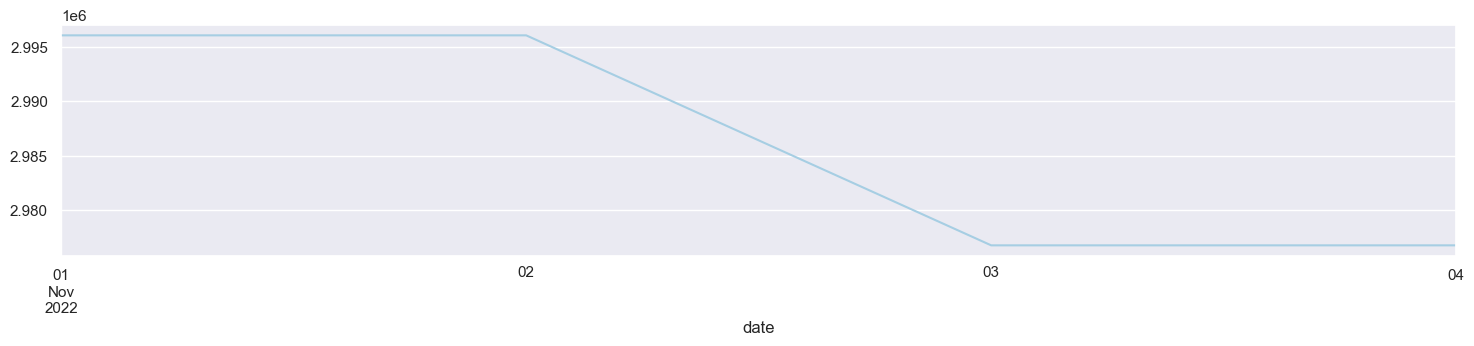

In [84]:
bitcoin_df = df[df.name.isin(["ethereum"]) == True]
bitcoin_df.set_index("date",inplace=True)
display(bitcoin_df)
bitcoin_df.twitter_followers.plot(figsize=(18,3))
plt.show()